<a href="https://colab.research.google.com/github/luisMendoza00/OnyxBot/blob/main/ActM1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# M1. Actividad  (Robot de Limpieza Reactivo)

---



**VacumAgent: **(Aspiradora) dedicado a la limpieza de las celdas sucias
**Floor: **(Piso) Genera el piso con las celdas sucias aletaoriamente

La aspiradora es capaz de moverse si encuentra que un vecino suyo esta sucio, si en dado caso no encuentra nignuno sucio se mueve de manera aleatoria.
Este programa se detiene hasta que el tiempo definido se agote o en dado caso quede totalmente limpio el piso.








## Reglas

Entrada:
* Habitación de MxN espacios.
* Número de agentes.
* Porcentaje de celdas inicialmente sucias.
* Tiempo máximo de ejecución (steps).


Salida:
* Tiempo máximo esta definido, terminando el programa si se supera el tiempo o queda completamente limpio el piso
* Muestra el porcentaje de las celdas que se alcanzaron a limpiar al termino de la simulación.
* Número de movimientos realizados por todos los agentes.
* El tiempo que nos llevo ejecutar el código
* Muestra una simulación de la limpieza
* Genera una gráfica con el porcentaje limpiado en los pasos
* Imprime el número de pasos

Fecha de creación/modificación: 21/05/2022
"""




## Imports

Antes de empezar a crear el modelo del juego de la vida con multiagentes es necesario tener instalado los siguientes paquetes:
- `python`: asegúrense de usar la versión 3+.
- `mesa`: el framework de Python para el modelado de agentes.
- `numpy`: es una biblioteca de Python para el manejo de matrices, arreglos, manipulación matemática, lógica y mucho más.
- `matplotlib`: es una biblioteca para crear visualizaciones estáticas, animadas e interactivas en Python.

Para poder modelar el juego de la vida usando el framework de `mesa` es necesario importar dos clases: una para el modelo general, y otro para los agentes. 

In [1]:
# Sino se tiene instalado el framework hay que realizar la instalación
!pip install mesa

     |████████████████████████████████| 691 kB 8.9 MB/s 
     |████████████████████████████████| 64 kB 1.6 MB/s 


In [2]:
# 'Model' sirve para definir los atributos a nivel del modelo, maneja los agentes
# 'Agent' es la unidad atómica y puede ser contenido en múltiples instancias en los modelos
from mesa import Agent, Model 

# 'SingleGrid' sirve para forzar a un solo objeto por celda (nuestro objetivo en este "juego")
from mesa.space import SingleGrid
from mesa.space import MultiGrid

# 'SimultaneousActivation' habilita la opción de activar todos los agentes de manera simultanea.
from mesa.time import SimultaneousActivation

# 'DataCollector' permite obtener el grid completo a cada paso (o generación), útil para visualizar
from mesa.datacollection import DataCollector

# 'matplotlib' lo usamos para graficar/visualizar como evoluciona el autómata celular.
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2 ** 128

# Definimos los siguientes paquetes para manejar valores númericos: 'numpy' & 'pandas'
import numpy as np
import pandas as pd

# Definimos otros paquetes que vamos a usar para medir el tiempo de ejecución de nuestro algoritmo.
import time
import datetime

## Crear el modelo

Antes que nada el presente modelo se encuentra basado en el [tutorial introductorio](https://mesa.readthedocs.io/en/latest/tutorials/intro_tutorial.html). Se modificó para que funcionara con el presente problema pero en esencia es lo mismo.

In [16]:
from os import closerange
class vacuumAgent(Agent):
    def __init__(self, unique_id, model):
      super().__init__(unique_id, model)
      self.next_pos = None

    def step(self):
      for agent in self.model.grid.get_cell_list_contents(self.pos):
        if isinstance(agent, floorAgent):
          floor = agent

      if floor.clean:
        neighbours = self.model.grid.get_neighbors(
              self.pos,
              moore=True,
              include_center=False)
        
        floor_neighbours = []
        for neighbour in neighbours:
          if isinstance(neighbour, floorAgent):
            floor_neighbours.append(neighbour)

        foundDirtyNeighbor = False
        for neighbor in floor_neighbours:
          if not neighbor.clean and not foundDirtyNeighbor:
            self.next_pos = neighbor.pos
            foundDirtyNeighbor = True
            break
        
        if not foundDirtyNeighbor:
          self.next_pos = np.random.choice(floor_neighbours).pos
      else:
        floor.clean = 1
        self.next_pos = self.pos


    def advance(self):
      self.model.grid.move_agent(self, self.next_pos)

      
      

class floorAgent(Agent):
    """
    Representa a un agente o una celda con estado vivo (1) o muerto (0)
    """
    def __init__(self, unique_id, model, average):
        """
        Crea un agente con estado inicial aleatorio de 0 ó 1, también se le asigna un identificador
        formado por una tupla (x,y). Se define un nuevo estado cuyo valor será definido por las
        reglas mencionadas arriba.
        """
        super().__init__(unique_id, model)
        # elegir no random, si esta bajo del porcentaje, ponerlo sucio

        self.clean = np.random.rand() < average
    
    def step(self):
        """
        Este método es el que calcula si la celda vivirá o morirá dependiendo el estado de sus vecinos.
        Esta es la dinámica principal del juego de la vida. Por lo tanto, el estado live de la
        siguiente generación no se cambia aquí, solo se almacena en self.next_state. La idea consiste
        en esperar a que todos los agentes calculen su estado y una vez hecho esto, hacer el cambio.
        """


    
    def advance(self):
        """
        Define el nuevo estado calculado del método step.
        """
            
class VacuumCleanModel(Model):
    """
    Define el modelo del juego de la vida.
    """
    def __init__(self, width, height, num_agents ,average):
        self.num_agents = num_agents
        self.grid = MultiGrid(width, height, True)
        self.schedule = SimultaneousActivation(self)
        self.performanceTable = {'Average': []}
        self.stepCount = 0
        
        for (content, x, y) in self.grid.coord_iter():
            a = floorAgent((x, y), self, average)
            self.grid.place_agent(a, (x, y))
            self.schedule.add(a)
        
        for i in range (self.num_agents):
            a = vacuumAgent(i, self)
            self.grid.place_agent(a, (1, 1))
            self.schedule.add(a)
        
        # Aquí definimos el colector de datos para obtener el grid completo.
        self.datacollector = DataCollector(
            model_reporters={"Grid": self.get_grid}
        )
    
    def step(self):
        """
        En cada paso el colector toma la información que se definió y almacena el grid para luego
        graficarlo.
        """
        self.datacollector.collect(self)
        self.schedule.step()

        self.performanceTable["Average"].append(self.cleanAverage() * 100)
        self.stepCount += 1
        

    def get_grid(self):
        """
        Esta es una función auxiliar que nos permite guardar el grid para cada uno de los agentes.
        :param model: El modelo del cual obtener el grid.
        :return: Matriz con la información del grid del agente.
        """

        # Generamos la grid para contener los valores
        grid = np.zeros((self.grid.width, self.grid.height))

        # Asignamos una celda a cada uno de los elementos de la grilla
        for cell in self.grid.coord_iter():
            cell_content, x, y = cell
            foundVacuum = False
            for agent in cell_content:
              if not foundVacuum:
                if isinstance(agent, vacuumAgent):
                  grid[x][y] = 2
                if isinstance(agent, floorAgent):
                  if agent.clean:
                    grid[x][y] = 0
                  else:
                    grid[x][y] = 1

        return grid
    
    def cleanAverage(self):
      isClean = 0
      for cell in self.grid.coord_iter():
        cell_content, x, y = cell
        for agent in cell_content:
          if isinstance(agent, floorAgent):
            isClean += agent.clean
      return isClean / sum(1 for _ in self.grid.coord_iter())




# Ejecución del modelo
A continuación corremos el modelo

In [32]:
# Definimos el tamaño del Grid
GRID_SIZE = 50

# Definimos el numero de agentes
NUM_AGENTS = 20

# Definimos el tiempo Maximo de ejecución 
EXECUTE_TIME = 5

NUM_GENERATIONS = 0

# Porcentaje de celdas sucias inicial
INIT_AVERAGE = 0.7

# Registramos el tiempo de inicio y corremos el modelo
start_time = time.time()
model = VacuumCleanModel(GRID_SIZE, GRID_SIZE, NUM_AGENTS , INIT_AVERAGE)

while ((time.time() - start_time) < EXECUTE_TIME) and not model.cleanAverage() == 1: 
  NUM_GENERATIONS += 1
  model.step()

# Guardamos el tiempo que le tomó correr al modelo.
runTime = datetime.timedelta(seconds=(time.time() - start_time))

Obtenemos la información que almacenó el colector, este nos entregará un DataFrame de pandas que contiene toda la información.

In [33]:
all_grid = model.datacollector.get_model_vars_dataframe()

Graficamos la información usando `matplotlib`

In [34]:
%%capture

fig, axs = plt.subplots(figsize=(7,7))
axs.set_xticks([])
axs.set_yticks([])
patch = plt.imshow(all_grid.iloc[0][0], cmap=plt.cm.binary)

def animate(i):
    patch.set_data(all_grid.iloc[i][0])
    
anim = animation.FuncAnimation(fig, animate, frames=NUM_GENERATIONS)

In [35]:
anim

Numero de Agentes:20
Numero de pasos:620
Tiempo de ejecución:  0:00:05.004930
Porcentaje de celdas limpias: 99.92%


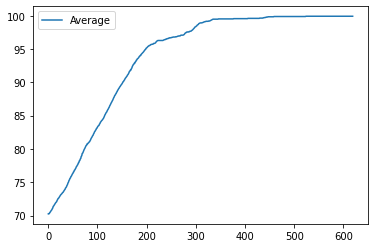

In [36]:
df = pd.DataFrame.from_dict(model.performanceTable)
df.plot()
print("Numero de Agentes:" + str(NUM_AGENTS))
print("Numero de pasos:" + str(model.stepCount))
# Imprimimos el tiempo que le tomó correr al modelo.
print('Tiempo de ejecución: ', str(runTime))
print('Porcentaje de celdas limpias: ' + str(model.cleanAverage() * 100) + '%')